In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
import scipy.stats as sps
import scipy.spatial as spt
from sklearn.cross_validation import train_test_split

import edward as ed
from edward.models import Normal, Dirichlet, Multinomial, Gamma, Empirical
from tensorflow.contrib.linalg import LinearOperatorTriL
import itertools
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')
import bijectors as bijector

/home/folzd/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Express a matrix of real-valued variables as a product of a binary matrix and a real-valued matrix:

\begin{align}
\mathbf{X} = \mathbf{M}\mathbf{G} + \mathbf{E}
\end{align}

where 
\begin{align}
\mathbf{X} \textrm{ is an } n\times d \textrm{ matrix of real-valued observations } \\
\mathbf{M} \textrm{ is an } n\times k \textrm{ matrix of cluster assignments, s.t. }\\ \pi_j \sim Dirichlet(\alpha),\\ \mathbf{M}_i \sim \mathrm{Multinomial}(\pi) \\
\mathbf{G} \textrm{ is a } k\times d \textrm{ matrix of cluster means, s.t. }\\ \pi_j \sim Dirichlet(\alpha),\\
\end{align}

tmp = Gamma(1.,1.)
tmp2 = Gamma(.5,.5)
x = np.arange(0,10.,0.01,dtype=np.float32)
px = tmp.prob(x).eval()
px2 = tmp2.prob(x).eval()
plt.plot(x,px,color='r')
plt.plot(x,px2,color='g')

In [2]:
np.linspace(0.1,10,8).shape

(8,)

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,15

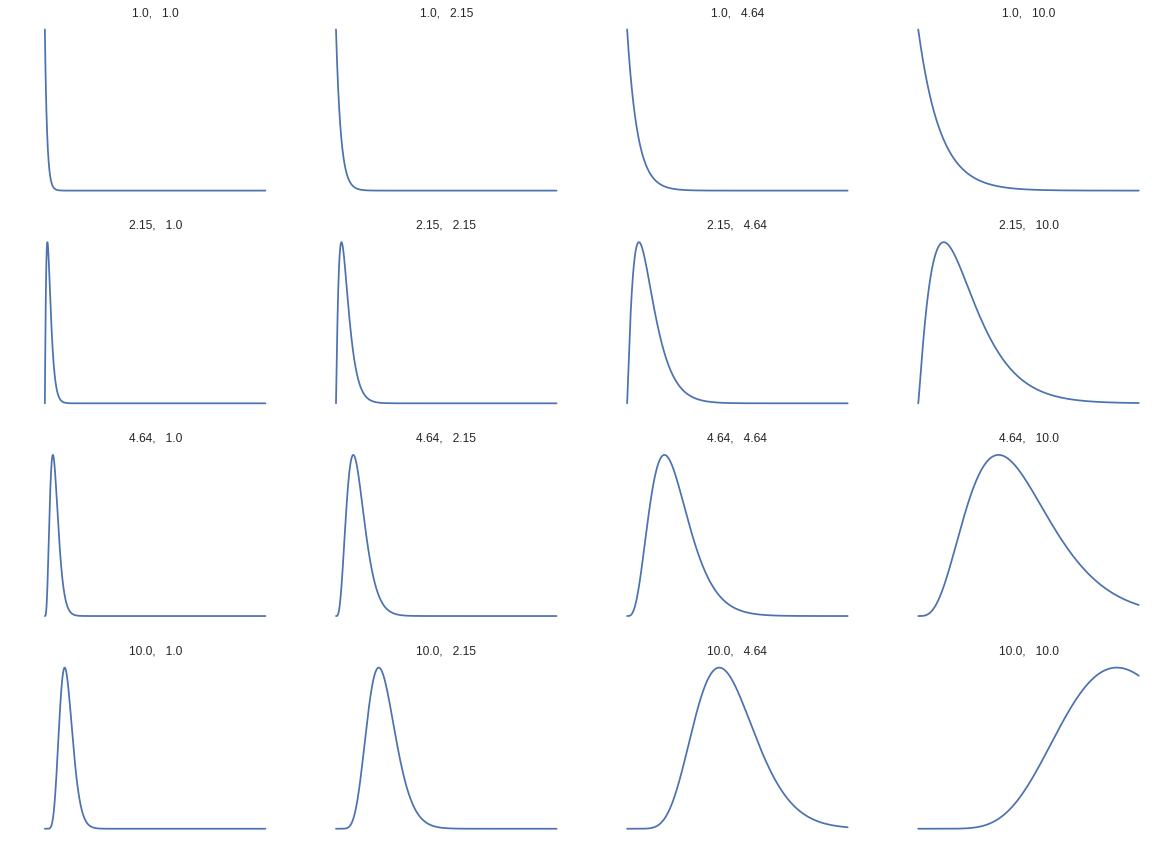

In [4]:
x = np.arange(0,100,0.01)
c = 1
for a in np.logspace(0,1,4):
    for b in np.logspace(0,1,4):
        plt.subplot(4,4,c)
        plt.title(str(np.round(a,2))+",   "+str(np.round(b,2)))
        plt.plot(x,sps.gamma.pdf(x=x,a=a,scale=b))
        plt.axis('off')
        c += 1

In [5]:
# from Gross et al. page 3
N = 100
K = 3
D = 2
# sample a clustering
def M(K,alpha = 1):
    pi = Dirichlet(np.atleast_1d(alpha*np.ones(K)).astype(np.float32))
    return Multinomial(total_count=1.,probs=pi) # to sample, run M.sample(sample_shape=n) because rows are iid

In [6]:
# sample cluster centers/ latent factors / factor weights / residuals
def G(K,D,a=1.,b=1.,**kwargs):
    # if i indexes observations, lambda_i is same for all i (default)
    # the bigger a and b, the higher the precision, the lower the variance
    lambda_i = tf.reshape(Gamma(a,b)*np.ones(K, dtype=np.float32), shape = (K,1))
    lambda_j = tf.reshape(Gamma(a*np.ones(D, dtype=np.float32),b*np.ones(D, dtype=np.float32)), shape = (1,D))
    variances = 1./lambda_i*1./lambda_j
    #print(variances.eval())
    return Normal(0.,variances) # this is a matrix of univariate Gaussians, not a multivariate Gauss

In [7]:
N,K,D

(100, 3, 2)

In [8]:
def plot_generated_data(mean_precision_shape,mean_precision_rate,obs_precision_shape,obs_precision_rate):
    sess = tf.Session()
    with sess.as_default():
        init = tf.global_variables_initializer()
        init.run()
        Mt = M(K).sample(sample_shape=N).eval()
        Gt = G(K,D,a=mean_precision_shape,b=mean_precision_rate).eval()
        Gnoise = G(N,D,a=obs_precision_shape,b=obs_precision_rate).eval()
        Xt = tf.matmul(Mt,Gt).eval()
        X = Xt + Gnoise
    plt.scatter(*X.T,color='g')
    plt.scatter(*Gt.T,color='r')
    plt.axis('equal');
    return X, Mt, Gt

In [9]:
def plot_generated_data_many_times(mean_precision_shape,mean_precision_rate,obs_precision_shape,obs_precision_rate):
    c = 1
    nrow = 3
    for i in range(nrow):
        for j in range(nrow):
            plt.subplot(nrow,nrow,c)
            plot_generated_data(mean_precision_shape,mean_precision_rate,obs_precision_shape,obs_precision_rate)
            c += 1

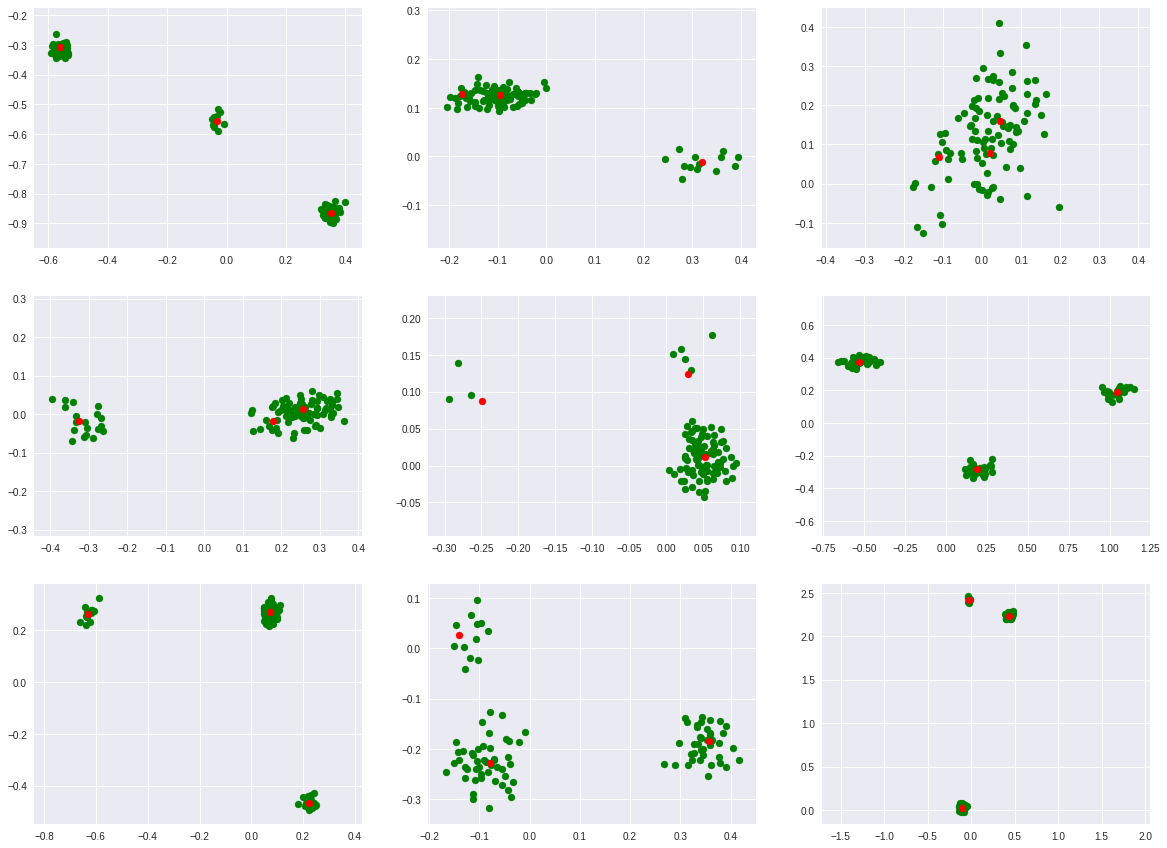

In [10]:
plot_generated_data_many_times(4.,2.,6.,1.)

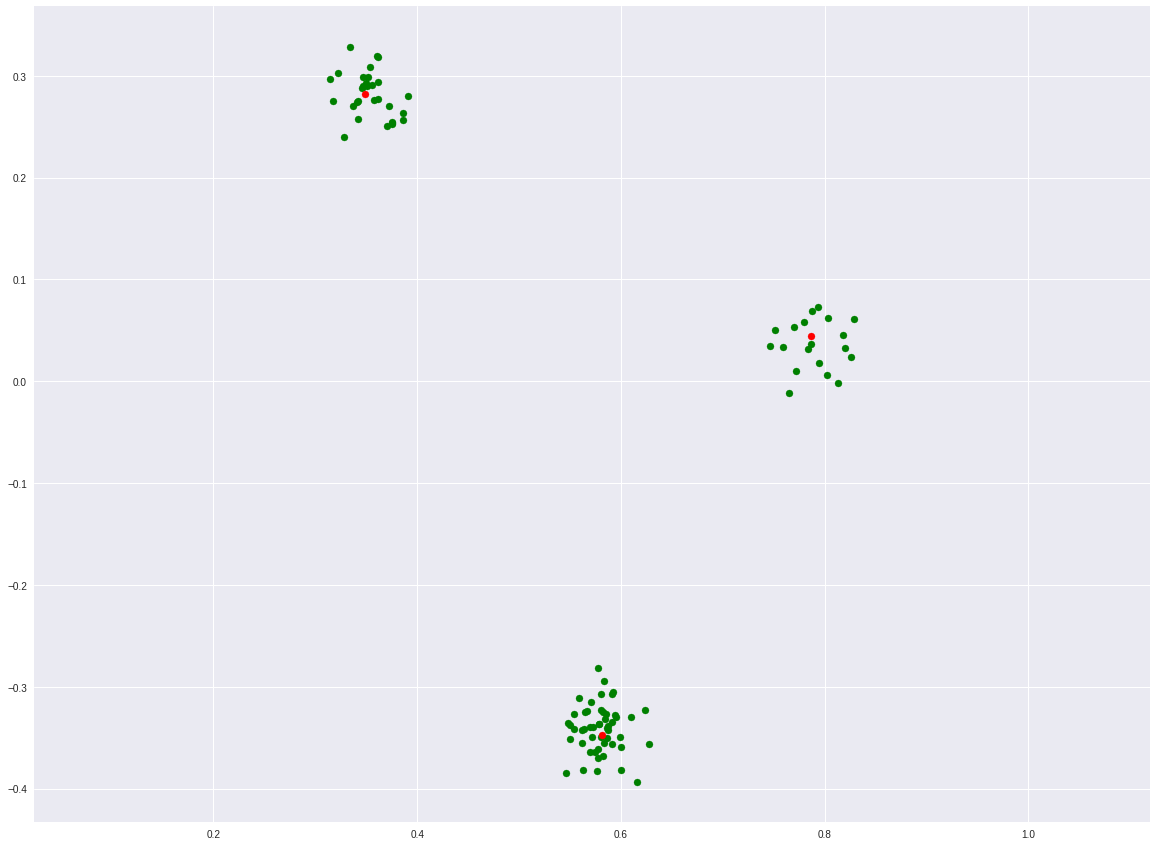

In [11]:
X, Mt, Gt = plot_generated_data(4.,2.,6.,1.)

In [13]:
# p model
alpha = 1
pi = Dirichlet(np.atleast_1d(alpha*np.ones(K)).astype(np.float32))
ui = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(pi,[N]),[N,K]))
g = G(K,D,a=4.,b=2.)
sigma_obs = ed.models.InverseGamma(6.*tf.ones([D]),1.*tf.ones([D]))
x = ed.models.MultivariateNormalDiag(tf.matmul(ui, g), tf.reshape(tf.tile(sigma_obs,[N]),[N,D]))

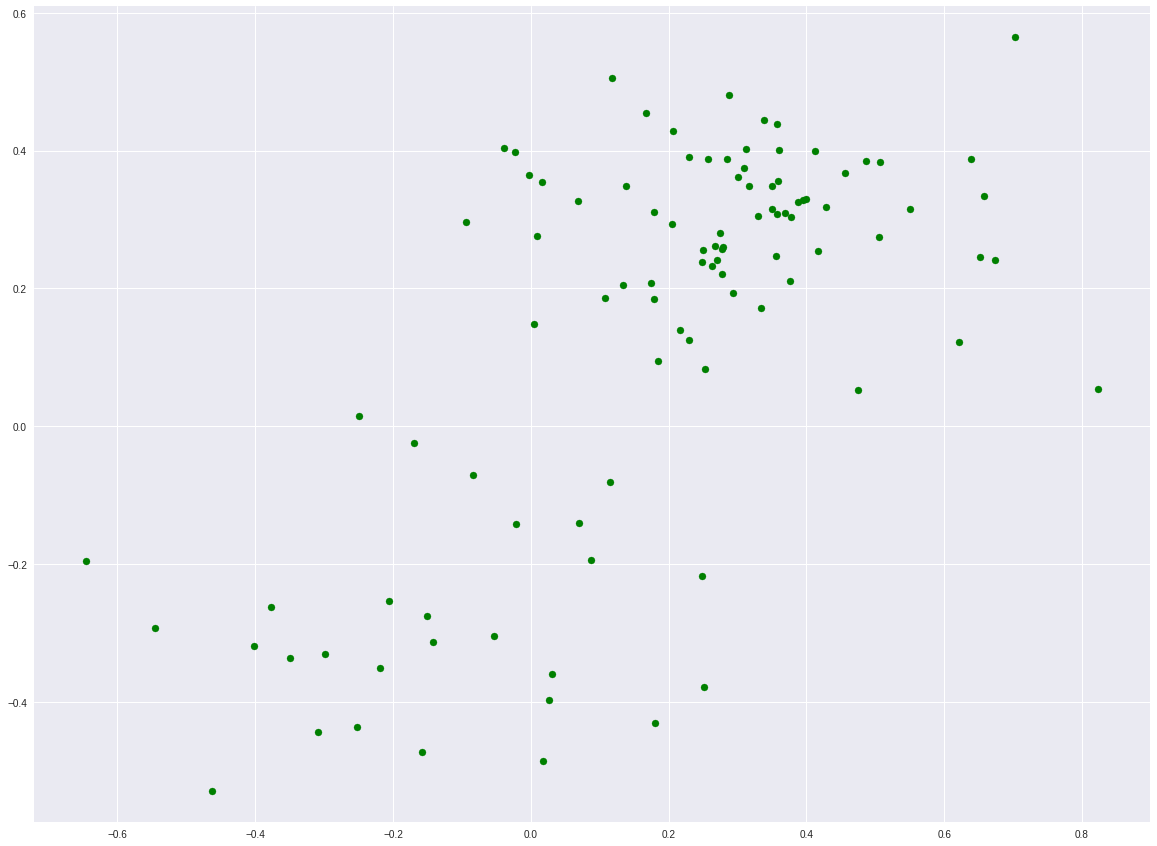

In [14]:
sess = tf.Session()
with sess.as_default():
    init = tf.global_variables_initializer()
    init.run()
    X_sample = x.sample().eval()
    plt.scatter(*X_sample.T,color='g')
    plt.axis('equal');

In [15]:
pi,ui,g,sigma_obs,x

(<ed.RandomVariable 'Dirichlet_32/' shape=(3,) dtype=float32>,
 <ed.RandomVariable 'Multinomial_42/' shape=(100, 3) dtype=float32>,
 <ed.RandomVariable 'Normal_62/' shape=(3, 2) dtype=float32>,
 <ed.RandomVariable 'InverseGamma_5/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'MultivariateNormalDiag_4/' shape=(100, 2) dtype=float32>)

In [16]:
# q model
# parameters
#qpi_mean = tf.nn.softmax(tf.Variable(tf.random_normal([K])))
alpha_hat = 0.1 + tf.nn.softplus(tf.Variable(tf.random_normal([K])))
qpi = Dirichlet(alpha_hat)
qui = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(qpi,[N]),[N,K]))
mu = tf.Variable(tf.random_normal([K,D]))
#sigma = tf.nn.softplus(tf.Variable(tf.random_gamma([K,D],1))*100)
qmeansigmamean = tf.Variable(tf.zeros(D))
qmeansigmastd = tf.Variable(tf.ones(D))
qmeansigma = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.reshape(tf.tile(qmeansigmamean,[K]),[K,D]),tf.reshape(tf.tile(qmeansigmastd,[K]),[K,D])),
    bijector=bijector.Exp(),
    name="qmeansigma")
qg = Normal(mu,qmeansigma)
qsigma = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
                                  tf.Variable(tf.ones(D))),
    bijector=bijector.Exp(),
    name="qsigma")

softplus_inverse = lambda x: np.log(np.exp(x) - 1.)

alpha_hat = 0.1 + tf.nn.softplus(tf.Variable((softplus_inverse(1)-.1)*tf.ones([K])))
qpi = Dirichlet(alpha_hat)
qui = Multinomial(total_count=1.,probs=tf.reshape(tf.tile(qpi,[N]),[N,K]))
mu = tf.Variable(Gt)
# 0.19607255  0.17728537
sigma = tf.nn.softplus(tf.Variable(tf.reshape(tf.tile(tf.constant([softplus_inverse(0.19607255), softplus_inverse(0.17728537)]),[K]),[K,D])))
qg = Normal(mu,sigma)
qsigma = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros(D)),
                                  tf.Variable(tf.ones(D))),
    bijector=bijector.Exp(),
    name="qsigma")

In [17]:
inference = ed.KLqp({pi: qpi, ui: qui, g: qg, sigma_obs:qsigma}, data={x: X})
#inference.initialize(n_iter=5000, n_print=10, n_samples=100)
inference.initialize(n_iter=10000, n_print=10, n_samples=50, optimizer='rmsprop')

sess = ed.get_session()
init = tf.global_variables_initializer()
init.run()

In [18]:
#alpha_hat.eval(), sigma.eval(), mu.eval()

{'loss': 41627.133, 't': 1}
{'loss': 307.67871, 't': 1001}
{'loss': 13.862864, 't': 2001}
{'loss': 8.5220919, 't': 3001}
{'loss': 7.1351609, 't': 4001}
{'loss': 7.5255723, 't': 5001}
{'loss': 9.8141251, 't': 6001}
{'loss': 6.2336736, 't': 7001}
{'loss': 6.1574836, 't': 8001}
{'loss': 9.5104837, 't': 9001}


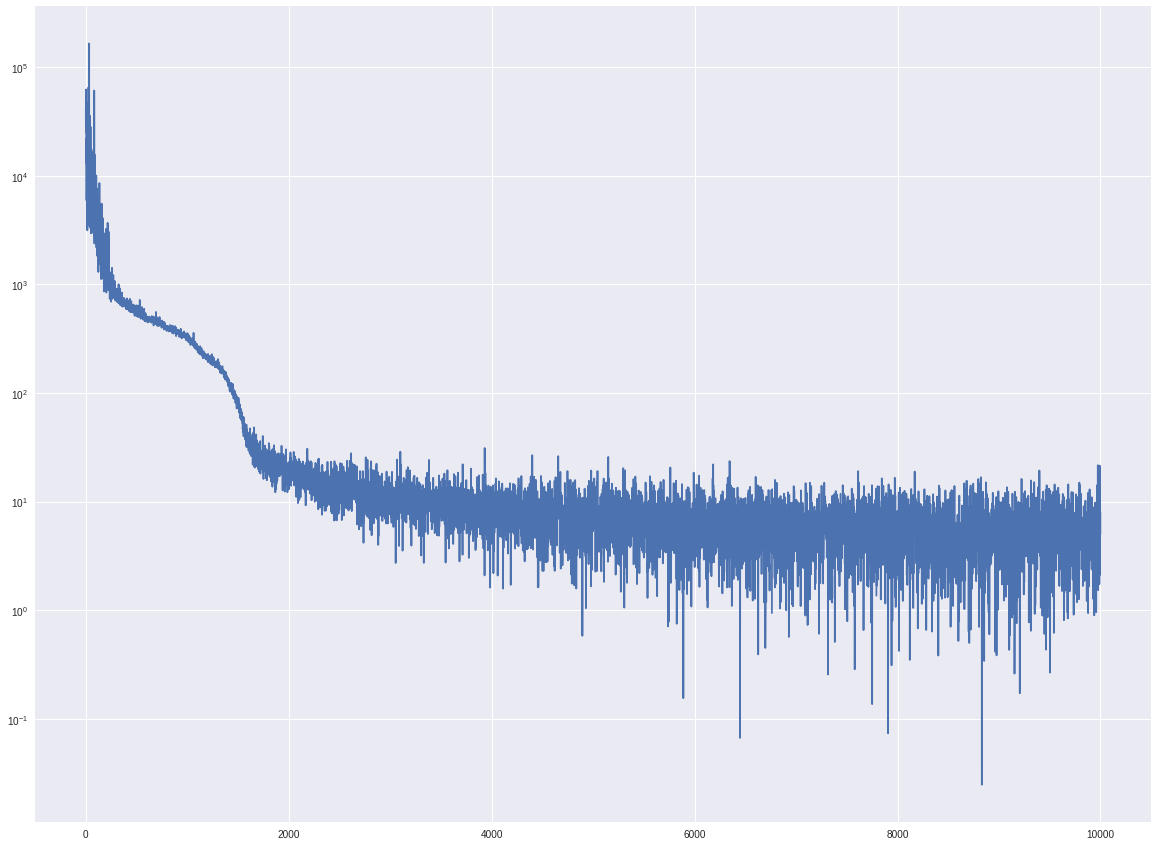

In [19]:
learning_curve = []
for _ in range(inference.n_iter):
    info_dict = inference.update()
    if _%1000 == 0:
        print(info_dict)
    learning_curve.append(info_dict['loss'])
plt.semilogy(learning_curve)

sigma.eval()

In [20]:
g.entropy().eval(),qg.entropy().eval()

(array([[-0.77495277, -0.6984235 ],
        [-0.77495277, -0.6984235 ],
        [-0.77495277, -0.6984235 ]], dtype=float32),
 array([[-2.15357351, -1.54743969],
        [-2.14972019, -1.5418216 ],
        [-2.17105341, -1.51107848]], dtype=float32))

In [21]:
x_hat = ed.copy(x, {pi: qpi, ui: qui, g: qg, sigma_obs:qsigma})

In [22]:
alpha_hat.eval()

array([ 12.67433167,  12.29920673,  12.44943905], dtype=float32)

In [23]:
Gt

array([[ 0.78672469,  0.04415876],
       [ 0.58113474, -0.34720623],
       [ 0.3486551 ,  0.28202924]], dtype=float32)

In [24]:
mu.eval()

array([[ 0.52871573, -0.06164337],
       [ 0.55394626, -0.05994228],
       [ 0.55177176, -0.04932763]], dtype=float32)

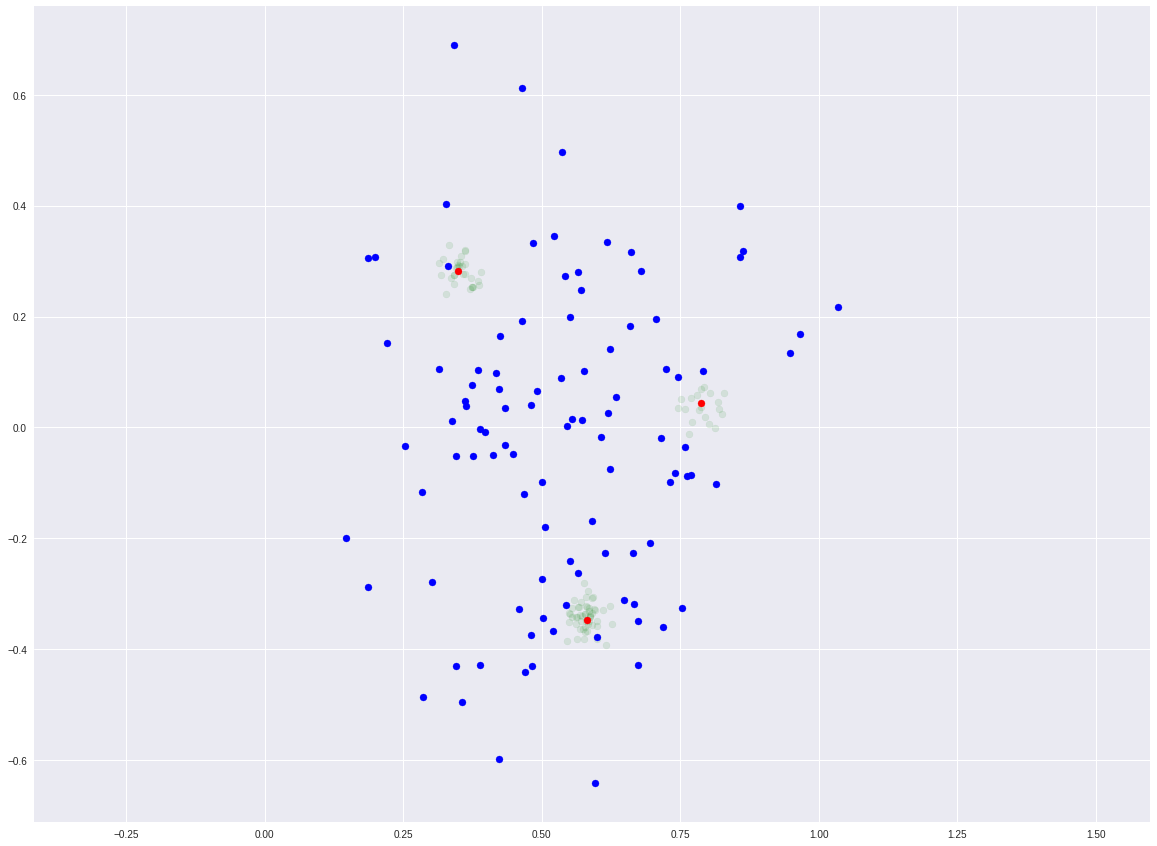

In [25]:
plt.scatter(*X.T,color='g', alpha=.1)
plt.scatter(*Gt.T,color='r')
plt.axis('equal');
X_sample = x_hat.sample().eval()
plt.scatter(*X_sample.T,color='b', alpha=1)
plt.axis('equal');